# Задание

Мы решили торговать на бирже, причем так, чтобы решение о покупке акций принимала нейросеть на основе последних новостей о той или иной компании. Для этого нужно научиться классифицировать все новости. Дана база новостей из разных источников news.csv. Необходимо написать классифицирующую модель новостей по источникам.

Напиши любую модель для предсказания источника новостей и предскажите источники для данных из файла news.csv, для которых отсутствует значение Source.

Пороговые значения для данной задачи классификации считать равными 0.33, 0.66.

Ответ необходимо прикрепить в файле формата CSV. Файл должен содержать только прогнозные значения Source в одном столбце без заголовка.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from pprint import pprint

In [31]:
from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import train_test_split

from tensorflow import keras
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Input, Dense, Dropout, BatchNormalization, Embedding, SpatialDropout1D, Flatten
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.metrics import Accuracy

In [44]:
from sklearn.metrics import accuracy_score, roc_auc_score, precision_score, recall_score, multilabel_confusion_matrix, ConfusionMatrixDisplay

In [4]:
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize, sent_tokenize
from nltk.stem import SnowballStemmer

import pymorphy2

from gensim.models.word2vec import Word2Vec
from gensim.utils import simple_preprocess
import gensim.downloader as api

nltk.download('stopwords')
nltk.download('punkt')

# из библиотеки Sklearn импортируем три наиболее популярных Vectorizer для работы с текстами
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer, HashingVectorizer

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\apple\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\apple\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [5]:
PPRINT_WIDTH = 160

Функции для записи и чтения обработанных текстов, т.к. данных достаточно много.

In [6]:
def list_of_str_to_txt(list_, file_name):
    with open(file_name, 'w', encoding='utf-8') as f:
        for item in list_:
            f.write("%s\n" % item)
            
def txt_to_str_list(file_name):
    with open(file_name, 'r', encoding='utf-8') as f:
        text = f.read().split('\n')
    return text

# Данные

In [7]:
data = pd.read_csv('news.csv')

In [8]:
data

,Unnamed: 0,news,source
0,0,Официальный аккаунт PlayStation опубликовал т...,1.0
1,1,Китайская компания Mobvoi опубликовала на офи...,1.0
2,2,Практически во всех странах мира введены огра...,0.0
3,3,"Депутат Госдумы, единоросс Антон Горелкин вне...",2.0
4,4,Совет директоров «Почты России» проголосовал ...,2.0
...,...,...,...
19457,19457,С 17 декабря в России блокируется один из кру...,NaN
19458,19458,Первые упоминания разработки тёмной темы в Go...,NaN
19459,19459,Компания Oppo презентовала два новых продукта...,NaN
19460,19460,"Основой презентации стала Windows 10, которая...",NaN


In [9]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 19462 entries, 0 to 19461
Data columns (total 3 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   Unnamed: 0  19462 non-null  int64  
 1   news        19462 non-null  object 
 2   source      18360 non-null  float64
dtypes: float64(1), int64(1), object(1)
memory usage: 456.3+ KB


датасет является несбалансированным

In [10]:
data['source'].value_counts()

1.0    11698
0.0     3455
2.0     3207
Name: source, dtype: int64

тренировочный датасет

In [11]:
df = data[~data['source'].isnull()][['news', 'source']].copy()
df.head()

,news,source
0,Официальный аккаунт PlayStation опубликовал т...,1.0
1,Китайская компания Mobvoi опубликовала на офи...,1.0
2,Практически во всех странах мира введены огра...,0.0
3,"Депутат Госдумы, единоросс Антон Горелкин вне...",2.0
4,Совет директоров «Почты России» проголосовал ...,2.0


In [12]:
#train_index = [int(x) for x in txt_to_str_list('train_x.txt') if x.isdigit()]
#test_index = [int(x) for x in txt_to_str_list('val_idx.txt') if x.isdigit()]

разделение на тренировочный и валидационный датасет осуществляем с учетом соотношения классов.

In [13]:
train_index, val_index = train_test_split(np.arange(df.shape[0]), stratify = df['source'], random_state=42)

x_train = df.iloc[train_index, 0].values
y_train = df.iloc[train_index, 1].values
x_val = df.iloc[val_index, 0].values
y_val = df.iloc[val_index, 1].values

#list_of_str_to_txt(train_index, 'train_idx.txt')
#list_of_str_to_txt(test_index, 'val_idx.txt')

In [57]:
print(x_train.shape, y_train.shape)
print(x_val.shape, y_val.shape)

(13770,) (13770,)
(4590,) (4590,)


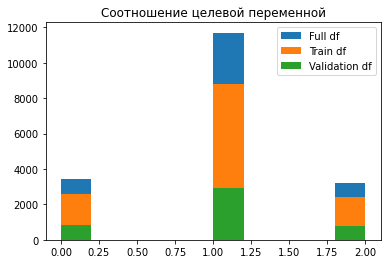

In [60]:
plt.hist(df['source'], label='Full df')
plt.hist(y_train, label='Train df')
plt.hist(y_val, label='Validation df')
plt.legend()
plt.title('Соотношение целевой переменной')
plt.show()

In [58]:
test_data = list(data[data['source'].isnull()]['news'])

In [59]:
pprint(x_train[1], width=PPRINT_WIDTH)
y_val[1]

(' Ведущий ныне закрытого телешоу «Разрушители легенд» Адам Сэвидж вернулся на канал Discovery с новым шоу Savage Builds. В первой серии он конструирует '
 'летающий и пуленепробиваемый костюм Железного человека. Броня Mark II напечатана на 3D-принтере из титана, нейлона и стекловолокна: модели Сэвидж получил от '
 'Marvel Studios. Она выдержала выстрел из пистолета калибра .22 с расстояния шести метров. Для того, чтобы заставить костюм летать, Сэвидж обратился к '
 'Ричарду Браунингу. Его компания Gravity Industries в 2017 году представила экзоскелет, позволяющий подниматься в воздух при помощи шести реактивных '
 'двигателей. В восьми сериях Savage Builds Адам Сэвидж вместе с другими экспертами и конструкторами будет собирать разные механизмы вроде автомобилей из '
 '«Безумного Макса» и самоходного боеприпаса Great Panjandrum . ')


2.0

# Предобработка текста

Порядок обработки текста:
* разбиваем текст на токены *nltk.tokenize.word_tokenize()*
* приводим токены книжнему регистру и оставляем только слова
* удаляем стоп-слова (те, что часто встречаются, но зачастую не несут в себе смысла, например предлоги, местоимения и т.д.) *nltk.corpus.stopwords*
* чистим от кавычек, которые могли случайно "приклеиться к словам"
* приводим все токены к нормальной форме (существительные -> им.п., ед.ч.; прилагательные -> им.п., ед.ч., м.р.; глаголы, причастия, деепричастия -> инфинитив несов. вида) *pymorphy2.MorphAnalyzer()*
Векторизация:
* будем использовать tfidf векторы *sklearn.feature_extraction.text.TfidfVectorizer*
* для обучения TfidfVectorizer создадим корпус на тренировочных данных с тремя документами, в каждом из которых будут тексты данного лейбла (0,1,2)

In [61]:
stop_words = stopwords.words('russian')
morph = pymorphy2.MorphAnalyzer()

def preprocess_rus(text):
    tokens = word_tokenize(text, language='russian')
    
    tokens = [i.lower() for i in tokens if i.isalnum()]
    tokens = [i.replace("«", "").replace("»", "").replace("'", "").replace('"', "") for i in tokens]
    tokens = [i for i in tokens if i not in stop_words]
    lemms = [morph.parse(i)[0].normal_form for i in tokens]
    text_cleared = ' '.join(lemms)
    
    return text_cleared

обрабатываем заново

In [62]:
%%time
#corpus_train_cleared = [preprocess_rus(text) for text in list(x_train)]

Wall time: 11min 20s


In [63]:
%%time
#corpus_val_cleared = [preprocess_rus(text) for text in list(x_val)]

Wall time: 3min 45s


In [64]:
%%time
#corpus_test_cleared = [preprocess_rus(text) for text in test_data]

Wall time: 55.6 s


сохраням обработанные

In [65]:
#list_of_str_to_txt(corpus_train_cleared, 'train_cleared.txt')
#list_of_str_to_txt(corpus_val_cleared, 'var_cleared.txt')
#list_of_str_to_txt(corpus_test_cleared, 'test_cleared.txt')

загружаем обработанные

In [17]:
#corpus_train_cleared = txt_to_str_list('train_cleared.txt')[:-1]
#corpus_val_cleared = txt_to_str_list('var_cleared.txt')[:-1]
#corpus_test_cleared = txt_to_str_list('test_cleared.txt')[:-1]

In [18]:
NUM_WORDS = 20000

In [19]:
def corpus_wrt_labels(X, y):
    data = pd.DataFrame({'X': X, 'y': y})
    
    corpus = []
    for label in data['y'].unique():
        text = list(data[data['y']==label]['X'])
        corpus.append(' '.join(text))
    return corpus

In [20]:
corpus_train_wrt_labels = corpus_wrt_labels(corpus_train_cleared, y_train)

In [21]:
vectorizer_02 = TfidfVectorizer(max_features = NUM_WORDS)

In [23]:
%%time
vectorizer_02.fit(corpus_train_wrt_labels)

Wall time: 2.81 s


TfidfVectorizer(max_features=20000)

In [24]:
vectorizer_02.vocabulary_

{'май': 10538,
 '2018': 238,
 'год': 7053,
 'президент': 14612,
 'владимир': 6211,
 'путин': 15380,
 'подписать': 13819,
 'утверждать': 18716,
 'нацпроект': 11572,
 'россия': 16154,
 'указ': 18453,
 'национальный': 11568,
 'цель': 19283,
 'стратегический': 17505,
 'задача': 8275,
 'развитие': 15504,
 'российский': 16153,
 'федерация': 18844,
 'период': 13434,
 '2024': 244,
 'направить': 11451,
 'обеспечение': 12156,
 'прорывный': 15187,
 'повышение': 13681,
 'уровень': 18625,
 'жизнь': 8143,
 'создание': 17046,
 'условие': 18653,
 'возможность': 6348,
 'самореализация': 16301,
 'раскрытие': 15700,
 'талант': 17766,
 'каждый': 9187,
 'человек': 19391,
 'многое': 11045,
 'развивать': 15501,
 'программа': 15008,
 'начать': 11577,
 'новый': 12065,
 'поставить': 14291,
 'кабмин': 9181,
 'амбициозный': 5013,
 'сформировать': 17664,
 'такой': 17757,
 'направление': 11453,
 'здравоохранение': 8637,
 'образование': 12256,
 'демография': 7448,
 'культура': 10123,
 'безопасный': 5429,
 'качествен

In [26]:
%%time
x_train_tfidf_02 = vectorizer_02.transform(corpus_train_cleared).toarray()
x_val_tfidf_02 = vectorizer_02.transform(corpus_val_cleared).toarray()
x_test_tfidf_02 = vectorizer_02.transform(corpus_test_cleared).toarray()

Wall time: 5.22 s


In [27]:
x_train_tfidf_02.shape

(13770, 20000)

# Модель

Закодируем таргет в OHE

In [28]:
target_encoder = OneHotEncoder(sparse=False)

In [29]:
y_train_01 = target_encoder.fit_transform(y_train.reshape([-1, 1]))
y_val_01 = target_encoder.fit_transform(y_val.reshape([-1, 1]))

In [30]:
n_classes = len(target_encoder.categories_[0])
target_encoder.categories_

[array([0., 1., 2.])]

Зададим простую модель с одним внутренним полносвязным слоем. Выходной функцией активации будет softmax, т.к. задача мультиклассовой классификации.

In [116]:
model_02 = Sequential()
model_02.add(Dense(64, input_dim=NUM_WORDS, activation='relu'))
model_02.add(BatchNormalization())
model_02.add(Dropout(0.4))
model_02.add(Dense(n_classes,activation='softmax'))

model_02.compile(optimizer=Adam(learning_rate=0.001),  loss='categorical_crossentropy',  metrics=['accuracy'])

model_02.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 64)                1280064   
_________________________________________________________________
batch_normalization_1 (Batch (None, 64)                256       
_________________________________________________________________
dropout_1 (Dropout)          (None, 64)                0         
_________________________________________________________________
dense_2 (Dense)              (None, 3)                 195       
Total params: 1,280,515
Trainable params: 1,280,387
Non-trainable params: 128
_________________________________________________________________


In [117]:
model_02.fit(x=x_train_tfidf_02,  y=y_train_01, epochs = 10, verbose = 1, validation_data= (x_val_tfidf_02, y_val_01))

Epoch 1/10
431/431 [==============================] - 8s 16ms/step - loss: 0.1931 - accuracy: 0.9348 - val_loss: 0.2231 - val_accuracy: 0.9283
Epoch 2/10
431/431 [==============================] - 5s 11ms/step - loss: 0.0365 - accuracy: 0.9894 - val_loss: 0.0791 - val_accuracy: 0.9730
Epoch 3/10
431/431 [==============================] - 5s 11ms/step - loss: 0.0172 - accuracy: 0.9947 - val_loss: 0.0885 - val_accuracy: 0.9723
Epoch 4/10
431/431 [==============================] - 5s 10ms/step - loss: 0.0135 - accuracy: 0.9962 - val_loss: 0.0903 - val_accuracy: 0.9739
Epoch 5/10
431/431 [==============================] - 4s 10ms/step - loss: 0.0066 - accuracy: 0.9984 - val_loss: 0.0882 - val_accuracy: 0.9767
Epoch 6/10
431/431 [==============================] - 4s 10ms/step - loss: 0.0082 - accuracy: 0.9973 - val_loss: 0.0940 - val_accuracy: 0.9721
Epoch 7/10
431/431 [==============================] - 4s 10ms/step - loss: 0.0069 - accuracy: 0.9982 - val_loss: 0.1082 - val_accuracy: 0.9725

In [118]:
model_02.save('model_02')

INFO:tensorflow:Assets written to: model_02\assets


Загрузим модель:

In [32]:
our_model = keras.models.load_model('model_02')

**посмотрим на метрики**

In [35]:
pred_02_train = our_model.predict(x_train_tfidf_02)
pred_02_train_class = np.argmax(pred_02_train, axis=1)
pred_02_val = our_model.predict(x_val_tfidf_02)
pred_02_val_class = np.argmax(pred_02_val, axis=1)

In [48]:
pred_02_train_01 = target_encoder.fit_transform(pred_02_train_class.reshape([-1, 1]))
pred_02_val_01 = target_encoder.fit_transform(pred_02_val_class.reshape([-1, 1]))

In [64]:
np.unique(pred_02_val_class, return_counts=True)

(array([0, 1, 2], dtype=int64), array([ 866, 2935,  789], dtype=int64))

In [57]:
conf_mat_train = multilabel_confusion_matrix(y_train_01, pred_02_train_01, labels=target_encoder.categories_[0])
conf_mat_val = multilabel_confusion_matrix(y_val, pred_02_val_class, labels=target_encoder.categories_[0])

In [93]:
def plot_conf_mat(conf_mat, title: str):
    fig, ax = plt.subplots(1, 3, figsize=(20,5))
    fig.suptitle(title)
    
    ConfusionMatrixDisplay(conf_mat[0]).plot(cmap='Greens', ax=ax[0])
    ax[0].set_title('1 - класс 0')
    ConfusionMatrixDisplay(conf_mat[1]).plot(cmap='Blues', ax=ax[1])
    ax[1].set_title('1 - класс 1')
    ConfusionMatrixDisplay(conf_mat[2]).plot(cmap='Purples', ax=ax[2])
    ax[2].set_title('1 - класс 2')

    plt.show()

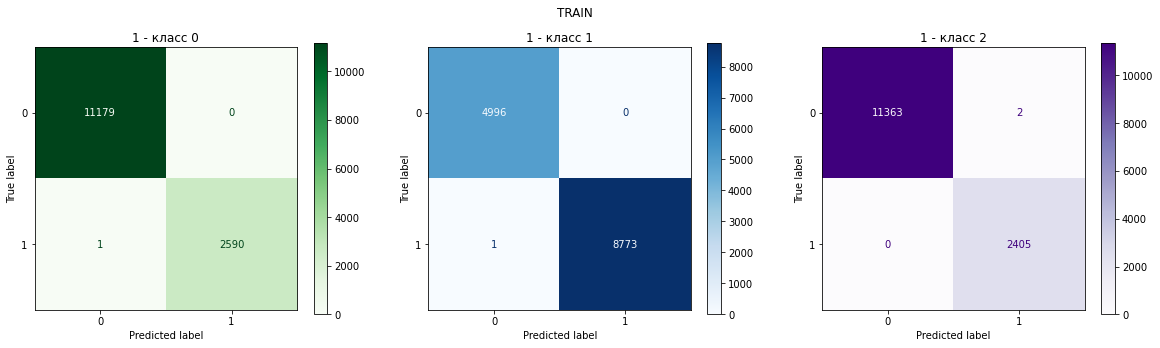

In [95]:
plot_conf_mat(conf_mat_train, 'TRAIN')

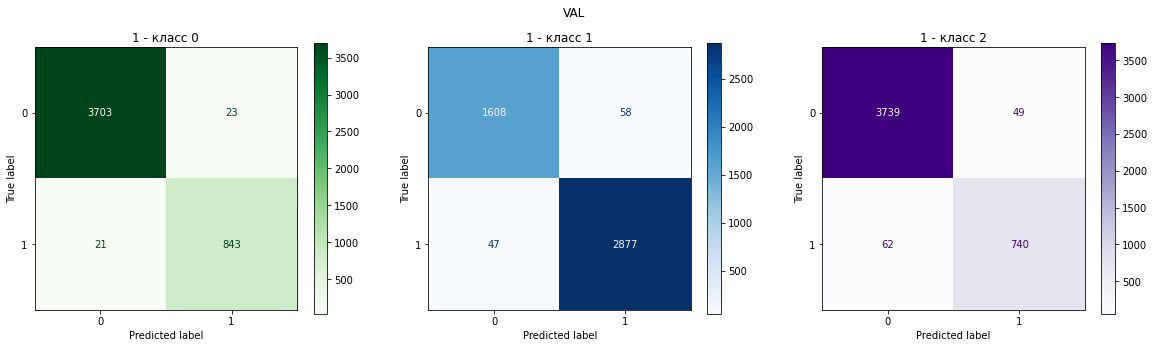

In [96]:
plot_conf_mat(conf_mat_val, 'VAL')

In [40]:
print('Accuracy')
print('Train: ', accuracy_score(y_train, pred_02_train_class))
print('Val  : ', accuracy_score(y_val, pred_02_val_class))
print('ROC AUC')
print('Train: ', roc_auc_score(y_train_01, pred_02_train_01))
print('Val  : ', roc_auc_score(y_val_01, pred_02_val_01))
print('Precision')
print('Train: ', precision_score(y_train, pred_02_train_class, average='weighted'))
print('Val:   ', precision_score(y_val, pred_02_val_class, average='weighted'))
print('Recall')
print('Train: ', recall_score(y_train, pred_02_train_class, average='weighted'))
print('Val:   ', recall_score(y_val, pred_02_val_class, average='weighted'))

Accuracy
Train:  0.9998547567175018
Val  :  0.971677559912854
ROC AUC
Train:  0.9998873494408319
Val  :  0.9713985814551145
Precision
Train:  0.9998548774015754
Val:    0.9715605976462368
Recall
Train:  0.9998547567175018
Val:    0.971677559912854


Сделаем предскаазние для тестовой выборки и отправим результат

In [100]:
pred_02_test = our_model.predict(x_test_tfidf_02)
pred_02_test_class = np.argmax(pred_02_test, axis=1)

In [116]:
def save_to_csv(ans, title: str):
    df = pd.DataFrame(ans, index=data[data['source'].isnull()].index, columns=['source'])
    df.to_csv(title)

In [117]:
save_to_csv(pred_02_test_class, 'pred_02_test.csv')

<img src="news_result.PNG" width="400">